# Assignment 3: Classification with CNN
Author: Theodore Janson - 260868223 <br>
Course: ECSE 415 <br>
Date: November 2nd, 2020
## 1 Image Classification using CNN


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time



%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/ECSE 415/Assignments/Assignment_3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!




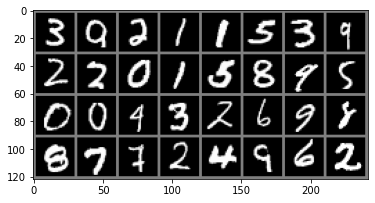

In [ ]:
#Normalizing data so that entries are in range [-0.5, 0.5]
normalize = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))])

#Loading MNIST data sets
train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=normalize)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=normalize)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False)

#Output classes
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

#Show an example images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))


In [ ]:
#CNN Architecture 
class CNN(nn.Module):
  def __init__(self):
    '''
    CNN Constructor
    '''
    super(CNN, self).__init__() 
    self.conv1 = nn.Conv2d(1, 32, 3)  #Convolutionary layer with 32 kernels of size 3x3
    self.conv2 = nn.Conv2d(32, 64, 3) #Convolutionary layer with 64 kernels of size 3x3
    self.pool = nn.MaxPool2d(2, 2)    #Max pool layer with kernels of size 2x2
    self.conv3 = nn.Conv2d(64, 64, 3) #Convolutionary layer with 64 kernels of size 3x3
    self.conv4 = nn.Conv2d(64, 64, 3) #Convolutionary layer with 64 kernels of size 3x3
    self.fc1 = nn.Linear(64*8*8, 10)  #Linear layer with output of size 10


  def forward(self, x):
    a0 = x #Layer 0 is made of features (vector of length 4096)
    a1 = self.conv1(a0) #Layer 0 convoluted 
    a1 = F.relu(a1)     #Layer 1 is RELU activations of convolutions
    a2 = self.conv2(a1) #Layer 1 is convoluted 
    a2 = F.relu(a2)     #Layer 2 is RELU activations of convolutions
    a2 = self.pool(a2)  #Max pooling on layer 2
    a3 = self.conv3(a2) #Layer 2 is convoluted 
    a3 = F.relu(a3)     #Layer 3 is RELU activations of convolutions
    a4 = self.conv4(a3) #Layer 3 is convoluted 
    a4 = F.relu(a4)     #Layer 3 is RELU activations of convolutions
    a4 = a4.view(-1, 64*8*8) #Flattening layer
    a5 = self.fc1(a4)   #Linear layer
    h = a5              #Hypothesis
    return h
net = CNN()
print(net)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
start = time.time()

#Create an instance of SGD optimizer with learning rate of 0.001. 
#Use the default setting for rest of the hyperparameters. 
#Create an instance of categorical cross entropy criterion. 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

#Train the CNN for 10 epochs. 
#Note: running time is very long for training with 10 epochs (~30 min),
#but 2 epochs yields reliable results. 
#Results for 10 epochs can be found in section 3 of Read Me. 
e_count = 10  # loop over the dataset 10 times
for epoch in range(e_count):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
finish = time.time()
print('Finished Training') 
print('Training time for {} epochs: {} m {} s'.format(e_count, int((finish-start)/60),int((finish-start)%60)))

Finished Training
Training time for 10 epochs: 29 m 16 s


In [ ]:
#Predicts labels of the test images using the above trained CNN. Measure
#and display classification accuracy.

_, predicted = torch.max(outputs, 1)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Training over {} epochs'.format(e_count))
print('Total Correct:', correct)
print('Total Tested:', total)
print('Accuracy of the network on the {} test images: {}%'.format(total,100*correct/total))

Training over 10 epochs
Total Correct: 9791
Total Tested: 10000
Accuracy of the network on the 10000 test images: 97.91%
